# Generate Reading Time Statistics
Uses Numpy to ascertain the mean, median, max, min, top range, middle range, and bottom range (by length) of the applications. Further, creates a distribution plot of words in applications based on these ranges, and estimates reading times in a grouped bar chart.

In [1]:
# Enable R output through IPython using RPy2
%load_ext rpy2.ipython

# SQLite3 database
import sqlite3
# NumPy: Linear algebra, random number capabilities, multi-dimensional data-container
import numpy as np
from numpy import log
# Pandas: Data structures and data analysis tools
import pandas as pd
# Datetime, Time, and Math: Date-manipulation, time- and math-related functions
from datetime import datetime, timedelta
import time, math
# Itertools: Iterators for efficient looping
from itertools import groupby
# Collections: High-performance container datatypes
from collections import defaultdict

# Correct auto-rounding
from __future__ import division

# Set up R environment
%R require(ggplot2)
%R require(reshape2)
%R require(gtable)
%R require(gridExtra)
%R require(cowplot)
%R require(ggthemes)

# RPy2: Bridge between Python and R
import rpy2.rinterface as ri
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr
base = importr('base')
stats = importr('stats')
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# R 'print' function, basic functionality
rprint = ro.globalenv.get("print")
base = importr('base')
stats = importr('stats')
datasets = importr('datasets')
grdevices = importr('grDevices')

# Enable inline display of images, including .png and .svg
from IPython.core.display import Image
from IPython.display import SVG, display
import uuid

# A simple function for returning an image inline in IPython after saving
grdevices = importr('grDevices')
def ggplot_notebook(gg, width = 800, height = 600):
    fn = '{uuid}.png'.format(uuid = uuid.uuid4())
    grdevices.png(fn, width = width, height = height)
    gg.plot()
    grdevices.dev_off()
    return Image(filename=fn)

In [2]:
# Read database, attach as Pandas dataframe
db = sqlite3.connect("Applications.db")
#WHERE number_words <= 189
df = pd.read_sql_query("SELECT * FROM applications ORDER BY date(date) DESC", db)
db.close()
words = df['number_words'].tolist()

In [3]:
# Pass Words to Numpy array, split in three parts, then find statistics
words = np.array(words)
words_array = np.array_split(words, 3)
words_mean = np.round(np.mean(words))
words_median = np.round(np.median(words))
words_max = np.max(words)
words_min = np.min(words)
words_top = np.round(np.mean(words_array[0]))
words_middle = np.round(np.mean(words_array[1]))
words_bottom = np.round(np.mean(words_array[2]))

# Find ranges of lengths in applications: Top, middle, and bottom
df_top = df[(df.number_words > words_top)]
df_middle = df[(df.number_words <= words_top) & (df.number_words >= words_bottom)]
df_bottom = df[(df.number_words < words_bottom)]

# Print general statistics
print 'Mean:', words_mean
print 'Median:', words_median
print 'Max:', words_max
print 'Min:', words_min
print 'Top:', words_top
print 'Middle:', words_middle
print 'Bottom:', words_bottom

Mean: 223.0
Median: 215.0
Max: 334
Min: 118
Top: 245.0
Middle: 227.0
Bottom: 198.0


In [4]:
# Calculate seconds to read and insert into 'ReadTimes' Dataframe
def secondsToRead(words):
    return (words / 150) * 60, (words / 250) * 60, (words / 300) * 60, (words / 350) * 60, (words / 450) * 60, (words / 575) * 60, (words / 675) * 60, (words / 800) * 60

ReadTimes = pd.DataFrame({'words': df['number_words']})
ReadTimes["x150"], ReadTimes["x250"], ReadTimes["x300"], ReadTimes["x350"], ReadTimes["x450"], ReadTimes["x575"], ReadTimes["x675"], ReadTimes["x800"] = zip(*ReadTimes["words"].map(secondsToRead))

In [5]:
# Define read times
gradeLevelTimes = (150, 250, 300, 350, 450, 575, 675, 800)

# Calculate means in length ranges
words_top_mean = np.mean(df_top['number_words'])
words_middle_mean = np.mean(df_middle['number_words'])
words_bottom_mean = np.mean(df_bottom['number_words'])

# Calculate minutes to read for each length range mean, somewhat clumsily
dfGradeTimes = pd.DataFrame(columns=["type", "x150", "x250", "x300", "x350", "x450", "x575", "x675", "x800"]) 
words_top_mean_data = pd.DataFrame([['Long', 
         words_top_mean / 150, 
         words_top_mean / 250, 
         words_top_mean / 300, 
         words_top_mean / 350, 
         words_top_mean / 450, 
         words_top_mean / 575, 
         words_top_mean / 675, 
         words_top_mean / 800]], columns=list(dfGradeTimes.columns.values))
dfGradeTimes = dfGradeTimes.append(words_top_mean_data, ignore_index=True)
words_middle_mean_data = pd.DataFrame([['Medium', 
         words_middle_mean / 150, 
         words_middle_mean / 250, 
         words_middle_mean / 300, 
         words_middle_mean / 350, 
         words_middle_mean / 450, 
         words_middle_mean / 575, 
         words_middle_mean / 675, 
         words_middle_mean / 800]], columns=list(dfGradeTimes.columns.values))
dfGradeTimes = dfGradeTimes.append(words_middle_mean_data, ignore_index=True)
words_bottom_mean_data = pd.DataFrame([['Short', 
         words_bottom_mean / 150, 
         words_bottom_mean / 250, 
         words_bottom_mean / 300, 
         words_bottom_mean / 350, 
         words_bottom_mean / 450, 
         words_bottom_mean / 575, 
         words_bottom_mean / 675, 
         words_bottom_mean / 800]], columns=list(dfGradeTimes.columns.values))
dfGradeTimes = dfGradeTimes.append(words_bottom_mean_data, ignore_index=True)
dfGradeTimes

,type,x150,x250,x300,x350,x450,x575,x675,x800
0,Long,1.882222,1.129333,0.941111,0.806667,0.627407,0.491014,0.418272,0.352917
1,Medium,1.440000,0.864000,0.720000,0.617143,0.480000,0.375652,0.320000,0.270000
2,Short,1.097500,0.658500,0.548750,0.470357,0.365833,0.286304,0.243889,0.205781


In [6]:
%R -i df
%R -i dfGradeTimes
# Pass Dataframes to R data.frames

In [7]:
%%R
# Generate Words distribution plot
blackwhite = FALSE
breaks <- quantile(df$number_words, probs = c(0, .33, .66, 1))
worddistributionplot <- ggplot(df, aes_string(x = "number_words")) + 
    geom_histogram(aes(y=..count.., fill=..count..), 
                   binwidth=1,
                   breaks=seq(breaks[["0%"]], breaks[["100%"]], by = ((breaks[["100%"]] - breaks[["0%"]]) / 3))
                   ) +
    ggtitle("Distribution of Words") +
    labs(y = "Application Count", x = "Words", fill = "") +
    #scale_fill_gradient(low="grey", high="black") +
    theme(plot.title = element_text(size = rel(1.2), vjust=2),
                  axis.title.x=element_text(vjust=0),
                  axis.title.y=element_text(vjust=1.5),
                  legend.position="none",
                  plot.margin=unit(c(.6,.3,.6,.3),"cm"))
if (blackwhite) {
    worddistributionplot = worddistributionplot + scale_fill_gradient(low="grey", high="black")
} else {
    worddistributionplot = worddistributionplot + scale_colour_brewer()
}
#worddistributionplot

In [8]:
%%R
# Generate Time to Read plot
blackwhite = FALSE
timereadlabels = c("150", "250", "300", "350", "450", "575", "675", "800")
melted <- melt(cbind(dfGradeTimes[1], as.matrix(dfGradeTimes[-1])), id = "type")
timereadplot <- ggplot(melted, aes(x = type, y = value, fill = variable)) +   
    geom_bar(aes(fill = variable), position = "dodge", stat="identity") +
    ggtitle("Time to read") +
    labs(y = "Minutes", x = "Applications", fill = "Words /min") +
    theme(plot.title = element_text(size = rel(1.2), vjust=2),
                  axis.title.x=element_text(vjust=0),
                  axis.title.y=element_text(vjust=1.5),
                  legend.position="bottom",
                  plot.margin=unit(c(.6,.3,.6,.3),"cm"))
if (blackwhite) {
    timereadplot = timereadplot + scale_fill_grey(labels = timereadlabels)
} else {
    timereadplot = timereadplot + scale_fill_brewer(palette = "BrBG", labels = timereadlabels)
}
#timereadplot

In [9]:
%%R
# Group the figures using cowplot plot.grid()
readingtime <- plot_grid(worddistributionplot, timereadplot, ncol = 1, align = "hv")
ggsave(file = "readingtime.svg", path = "Plots", plot = readingtime, width = 10, height = 8, dpi = 100)

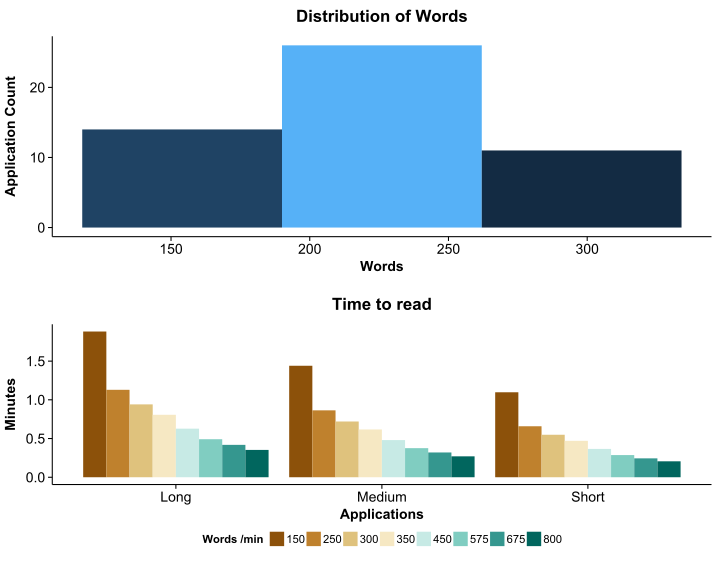

In [10]:
# Display the complete Consensus plot
display(SVG(filename='Plots/readingtime.svg'))